- This notebook is to try fine-tune the classifier after incorporating the actual experimental data

In [1]:
pwd

'/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/code/notebooks'

In [1]:
import os

In [2]:
import sys
sys.path.append("../src/models")
sys.path.append("../src")
sys.path.append("../")

In [3]:
from joblib import load

In [4]:
import numpy as np
import pandas as pd
import pickle

from Extrapolability import get_sample_fromGP, get_sample_lack_feature, classifier_performance_update, get_sample_lack_features_mul
from utils import *

# from xgboost import XGBClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF  
from sklearn.ensemble import RandomForestClassifier

In [83]:
new_data_path = '/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/code/notebooks/results_generate_experimental_plan1_20250606.pkl'
data = load(new_data_path)

In [84]:
model_clf = data["model_clf"]
x_smi_ori = data["x_smi_ori"]
y_pred_ori = data["y_pred_ori"]
x_smi_similar1 = data["x_smi_similar1"]
y_pred1 = data["y_pred1"]
x_smi_similar2 = data["x_smi_similar2"]
y_pred2 = data["y_pred2"]
x_smi_similar3 = data["x_smi_similar3"]
y_pred3 = data["y_pred3"]
x_smi_similar4 = data["x_smi_similar4"]
y_pred4 = data["y_pred4"]
df_new1 = data["df_new1"]
df_new2 = data["df_new2"]
df_new3 = data["df_new3"]
df_new4 = data["df_new4"]

In [7]:
model_clf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [22]:
# Function to merge features with label
def merge_features_and_label(x_df, y_series):
    df = x_df.copy()
    df["vesicles_formation"] = y_series
    return df

# Process each dataset
df1 = merge_features_and_label(data["x_smi_similar1"], data["y_pred1"])
df2 = merge_features_and_label(data["x_smi_similar2"], data["y_pred2"])
df3 = merge_features_and_label(data["x_smi_similar3"], data["y_pred3"])
df4 = merge_features_and_label(data["x_smi_similar4"], data["y_pred4"])

In [23]:
df1

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,vesicles_formation
0,1.506218,-2.200511,0.512130,2.141110,2.383503,-3.696073,6.637925,0.474857,4.481620,1.378513,...,-0.886180,1.347346,1.317521,-2.890483,2.700665,-3.143704,5.104757,3.185609,-0.146272,0.43
1,1.916849,-2.737870,0.678104,2.677290,2.978238,-4.664344,8.258685,0.625642,5.770261,1.621226,...,-1.152558,1.737311,1.909753,-3.576313,3.350638,-3.820145,6.228300,4.037046,-0.305792,1.00
2,1.109325,-1.479929,0.360874,1.473417,1.564458,-2.590239,4.543460,0.333235,3.101226,0.908712,...,-0.647232,0.999408,0.978756,-1.998060,1.834724,-2.100217,3.440247,2.215874,-0.183156,0.06
3,1.278161,-1.683607,0.433094,1.714104,1.835158,-3.002583,5.226595,0.397537,3.677695,1.013844,...,-0.779022,1.156845,1.211383,-2.272763,2.102722,-2.378255,3.939164,2.561011,-0.199792,0.74
4,1.256428,-1.828965,0.417047,1.703113,1.864885,-2.999425,5.406694,0.386552,3.516550,1.110577,...,-0.650506,1.114391,1.087143,-2.397303,2.201907,-2.577306,4.075585,2.631359,-0.282824,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.519411,-2.071675,0.506148,2.063934,2.264591,-3.580028,6.285384,0.461027,4.336516,1.265859,...,-0.944174,1.362431,1.344437,-2.704806,2.554428,-2.911942,4.776485,3.037427,-0.117207,0.45
996,1.601057,-2.142728,0.540946,2.141112,2.314800,-3.770867,6.614182,0.494941,4.536297,1.298548,...,-0.936065,1.428109,1.454380,-2.877360,2.635333,-3.027810,4.974082,3.225812,-0.248061,0.58
997,1.692388,-2.209855,0.545394,2.247509,2.339365,-3.999239,7.006113,0.511040,4.767865,1.398731,...,-0.965311,1.524443,1.467789,-3.115276,2.752835,-3.198115,5.333614,3.411861,-0.304981,0.53
998,1.206733,-1.632257,0.429278,1.650198,1.831094,-2.862224,4.949624,0.389849,3.614439,0.933119,...,-0.798961,1.105898,1.266548,-2.100281,2.020021,-2.232375,3.700633,2.436370,-0.135080,0.96


In [ ]:
# Now need to get index or just incorporate samples that have been experimented

In [14]:
output_file = "selected_samples_20250603.pkl"

with open(output_file, 'rb') as f:
    loaded_list = pickle.load(f)

In [15]:
high_samples0 = loaded_list[0]
low_samples0 = loaded_list[1]
high_samples1 = loaded_list[2] # High_replace_smi1
low_samples1 = loaded_list[3] # Low_replace_smi1
high_samples2 = loaded_list[4] # High_replace_smi5
low_samples2 = loaded_list[5] # Low_replace_smi5
high_samples3 = loaded_list[6] # High_replace_dismis1
low_samples3 = loaded_list[7] # Low_replace_dismis1
high_samples4 = loaded_list[8] # High_replace_dismis3
low_samples4 = loaded_list[9] # Low_replace_dismis3

In [26]:
def create_labeled_subset(df, high_df, low_df, base_label):
    # Get indices
    high_idx = high_df.index
    low_idx = low_df.index
    
    # Subset and assign category labels
    high_subset = df.loc[high_idx].copy()
    high_subset["category"] = f"High_{base_label}"

    low_subset = df.loc[low_idx].copy()
    low_subset["category"] = f"Low_{base_label}"

    # Combine
    subset = pd.concat([high_subset, low_subset])
    return subset

# Create subsets with only one 'category' column
subset1 = create_labeled_subset(df1, loaded_list[2], loaded_list[3], "replace_smi1")
subset2 = create_labeled_subset(df2, loaded_list[4], loaded_list[5], "replace_smi5")
subset3 = create_labeled_subset(df3, loaded_list[6], loaded_list[7], "replace_dismis1")
subset4 = create_labeled_subset(df4, loaded_list[8], loaded_list[9], "replace_dismis3")


In [28]:
subset_com = pd.concat([subset3, subset4, subset1, subset2])

In [29]:
subset_com

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,vesicles_formation,category
1,1.919059,-2.795643,0.672800,2.646035,3.096013,-4.497876,7.963376,0.653461,5.841252,1.453500,...,1.668498,1.999311,-3.560475,3.436900,-3.895547,5.976206,3.915713,-0.350417,0.99,High_replace_dismis1
372,1.070497,-1.466895,0.390864,1.394137,1.650020,-2.351985,4.156421,0.331879,3.042414,0.750346,...,0.936316,1.096909,-1.710248,1.688295,-1.888852,3.002744,2.054063,-0.108460,0.92,High_replace_dismis1
400,2.618945,-4.080359,0.944787,3.528536,4.394513,-5.846700,10.896799,0.851640,7.706958,2.017853,...,2.186525,2.576653,-4.768456,4.563787,-5.390245,7.988658,5.344394,-0.527295,0.99,High_replace_dismis1
441,1.547953,-2.182704,0.562976,2.021102,2.439071,-3.390893,6.072045,0.495044,4.465445,1.070235,...,1.321277,1.592281,-2.580181,2.499296,-2.850956,4.395580,3.004299,-0.236141,0.97,High_replace_dismis1
447,2.265684,-3.533000,0.837546,3.099242,3.778109,-5.168629,9.672284,0.722949,6.712982,1.863919,...,1.951863,2.235531,-4.122997,3.915451,-4.622681,7.098728,4.739542,-0.435254,1.00,High_replace_dismis1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.833348,-1.168039,0.245692,1.060340,1.172207,-1.807139,3.189455,0.244511,2.152227,0.649461,...,0.703429,0.715607,-1.415187,1.379081,-1.592623,2.351342,1.519014,-0.163208,0.10,Low_replace_smi5
128,0.892480,-1.308847,0.269715,1.182209,1.431075,-2.004078,3.477060,0.248597,2.422417,0.693050,...,0.740597,0.776767,-1.455183,1.465376,-1.720235,2.596701,1.650891,0.006977,0.09,Low_replace_smi5
624,0.824193,-1.116147,0.234426,1.042386,1.147506,-1.754777,3.086602,0.235499,2.092205,0.621646,...,0.694979,0.692578,-1.365823,1.332433,-1.520827,2.278786,1.474050,-0.155328,0.07,Low_replace_smi5
874,1.151207,-1.542937,0.318400,1.455890,1.625399,-2.490540,4.294374,0.300047,2.908533,0.865228,...,0.971944,0.890100,-1.856990,1.789607,-2.088712,3.230174,2.059528,-0.082174,0.04,Low_replace_smi5


In [35]:
subset_com_reset = subset_com.reset_index(drop=True)
subset_com_reset 

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,0,1,2,3,4,5,6,7,8,9,...,760,761,762,763,764,765,766,767,vesicles_formation,category
0,1.919059,-2.795643,0.672800,2.646035,3.096013,-4.497876,7.963376,0.653461,5.841252,1.453500,...,1.668498,1.999311,-3.560475,3.436900,-3.895547,5.976206,3.915713,-0.350417,0.99,High_replace_dismis1
1,1.070497,-1.466895,0.390864,1.394137,1.650020,-2.351985,4.156421,0.331879,3.042414,0.750346,...,0.936316,1.096909,-1.710248,1.688295,-1.888852,3.002744,2.054063,-0.108460,0.92,High_replace_dismis1
2,2.618945,-4.080359,0.944787,3.528536,4.394513,-5.846700,10.896799,0.851640,7.706958,2.017853,...,2.186525,2.576653,-4.768456,4.563787,-5.390245,7.988658,5.344394,-0.527295,0.99,High_replace_dismis1
3,1.547953,-2.182704,0.562976,2.021102,2.439071,-3.390893,6.072045,0.495044,4.465445,1.070235,...,1.321277,1.592281,-2.580181,2.499296,-2.850956,4.395580,3.004299,-0.236141,0.97,High_replace_dismis1
4,2.265684,-3.533000,0.837546,3.099242,3.778109,-5.168629,9.672284,0.722949,6.712982,1.863919,...,1.951863,2.235531,-4.122997,3.915451,-4.622681,7.098728,4.739542,-0.435254,1.00,High_replace_dismis1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.833348,-1.168039,0.245692,1.060340,1.172207,-1.807139,3.189455,0.244511,2.152227,0.649461,...,0.703429,0.715607,-1.415187,1.379081,-1.592623,2.351342,1.519014,-0.163208,0.10,Low_replace_smi5
76,0.892480,-1.308847,0.269715,1.182209,1.431075,-2.004078,3.477060,0.248597,2.422417,0.693050,...,0.740597,0.776767,-1.455183,1.465376,-1.720235,2.596701,1.650891,0.006977,0.09,Low_replace_smi5
77,0.824193,-1.116147,0.234426,1.042386,1.147506,-1.754777,3.086602,0.235499,2.092205,0.621646,...,0.694979,0.692578,-1.365823,1.332433,-1.520827,2.278786,1.474050,-0.155328,0.07,Low_replace_smi5
78,1.151207,-1.542937,0.318400,1.455890,1.625399,-2.490540,4.294374,0.300047,2.908533,0.865228,...,0.971944,0.890100,-1.856990,1.789607,-2.088712,3.230174,2.059528,-0.082174,0.04,Low_replace_smi5


In [34]:
subset_com.to_csv('subset_com_fm_20250806.csv', index=False)

In [31]:
df_avg = pd.read_csv('/Users/haoliu/Documents/GitHub/MicroscopyAnalysis/df_avg_fm_20250806.csv')

In [41]:
df_exp = pd.concat([subset_com_reset, df_avg.iloc[20:, 1:].reset_index(drop=True)], axis=1)

In [42]:
df_exp

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,vesicles_formation,category,num_vesicles_avg
0,1.919059,-2.795643,0.672800,2.646035,3.096013,-4.497876,7.963376,0.653461,5.841252,1.453500,...,1.999311,-3.560475,3.436900,-3.895547,5.976206,3.915713,-0.350417,0.99,High_replace_dismis1,18
1,1.070497,-1.466895,0.390864,1.394137,1.650020,-2.351985,4.156421,0.331879,3.042414,0.750346,...,1.096909,-1.710248,1.688295,-1.888852,3.002744,2.054063,-0.108460,0.92,High_replace_dismis1,5
2,2.618945,-4.080359,0.944787,3.528536,4.394513,-5.846700,10.896799,0.851640,7.706958,2.017853,...,2.576653,-4.768456,4.563787,-5.390245,7.988658,5.344394,-0.527295,0.99,High_replace_dismis1,32
3,1.547953,-2.182704,0.562976,2.021102,2.439071,-3.390893,6.072045,0.495044,4.465445,1.070235,...,1.592281,-2.580181,2.499296,-2.850956,4.395580,3.004299,-0.236141,0.97,High_replace_dismis1,22
4,2.265684,-3.533000,0.837546,3.099242,3.778109,-5.168629,9.672284,0.722949,6.712982,1.863919,...,2.235531,-4.122997,3.915451,-4.622681,7.098728,4.739542,-0.435254,1.00,High_replace_dismis1,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.833348,-1.168039,0.245692,1.060340,1.172207,-1.807139,3.189455,0.244511,2.152227,0.649461,...,0.715607,-1.415187,1.379081,-1.592623,2.351342,1.519014,-0.163208,0.10,Low_replace_smi5,2
76,0.892480,-1.308847,0.269715,1.182209,1.431075,-2.004078,3.477060,0.248597,2.422417,0.693050,...,0.776767,-1.455183,1.465376,-1.720235,2.596701,1.650891,0.006977,0.09,Low_replace_smi5,0
77,0.824193,-1.116147,0.234426,1.042386,1.147506,-1.754777,3.086602,0.235499,2.092205,0.621646,...,0.692578,-1.365823,1.332433,-1.520827,2.278786,1.474050,-0.155328,0.07,Low_replace_smi5,0
78,1.151207,-1.542937,0.318400,1.455890,1.625399,-2.490540,4.294374,0.300047,2.908533,0.865228,...,0.890100,-1.856990,1.789607,-2.088712,3.230174,2.059528,-0.082174,0.04,Low_replace_smi5,0


In [43]:
df_exp.to_csv('df_exp_fm_20250806.csv', index=False)

In [11]:
# So the old model is model_clf
# Now we may need add these new data to establish a new model: model_clf_new

In [12]:
# 1. get the old traning data set

In [8]:
model_path = '/Users/haoliu/Documents/GitHub/MicroscopyAnalysis/GPC_model_20240713.pkl' # GP model
info_path = '/Users/haoliu/Documents/Hao/Fordham/Cheminformatics/MD/Amphiphiles/Info.csv' # 7 amphipihles in AL paper

# Data set with only old molecules
Feature = ['All_features_reserved']
df1, model_gp = get_sample_fromGP(model_path, info_path, Feature)

# Original dataset
x_smi = get_latent_space(df1)
xtrain = x_smi
ytrain = df1['vesicles_formation']

Random Seed: 12345
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding
Using Rotation Embedding


/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


Vocab size: 2393
[INFERENCE MODE - smi-ted-Light]


100%|██████████| 7/7 [00:01<00:00,  6.27it/s]
/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/code/notebooks/../src/utils.py:80: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_train_emb = train_df.applymap(lambda x: replace_with_list(x, train_dict))


In [9]:
df_init =  pd.concat([xtrain, ytrain], axis=1)

In [10]:
df_init

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,vesicles_formation
0,1.503763,-2.394506,0.565644,2.119263,2.593276,-3.538527,6.665437,0.483833,4.537110,1.326907,...,-0.954011,1.293370,1.432294,-2.809182,2.651045,-3.168917,4.941082,3.229484,-0.213131,1
1,1.916763,-2.744539,0.679943,2.676537,2.985449,-4.658925,8.259628,0.625952,5.772167,1.619451,...,-1.154890,1.735454,1.913698,-3.573515,3.348932,-3.821009,6.222672,4.038553,-0.308090,1
2,1.107173,-1.649976,0.407782,1.454267,1.748334,-2.452138,4.567574,0.341102,3.149865,0.863476,...,-0.706689,0.952095,1.079361,-1.926794,1.791228,-2.122316,3.296775,2.254332,-0.241761,1
3,1.276291,-1.831395,0.473862,1.697460,1.994966,-2.882559,5.247553,0.404374,3.719967,0.974529,...,-0.830697,1.115724,1.298819,-2.210824,2.064919,-2.397461,3.814471,2.594434,-0.250726,1
4,1.255728,-1.884223,0.432290,1.696890,1.924637,-2.954548,5.414528,0.389109,3.532355,1.095877,...,-0.669827,1.099016,1.119835,-2.374144,2.187772,-2.584487,4.028962,2.643856,-0.301868,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.516704,-2.285700,0.565188,2.039831,2.496022,-3.406213,6.315736,0.470929,4.397735,1.208924,...,-1.019009,1.302881,1.471060,-2.615110,2.499684,-2.939757,4.595909,3.085832,-0.190969,1
996,1.599268,-2.284027,0.579924,2.125199,2.467591,-3.656112,6.634218,0.501479,4.576713,1.260959,...,-0.985472,1.388793,1.537978,-2.818141,2.599190,-3.046173,4.854863,3.257768,-0.296759,1
997,1.688555,-2.512781,0.628958,2.213393,2.666929,-3.753222,7.049070,0.525055,4.854511,1.318146,...,-1.071231,1.440156,1.647010,-2.988321,2.675350,-3.237484,5.078026,3.480371,-0.409382,1
998,1.206604,-1.642324,0.432055,1.649063,1.841980,-2.854046,4.951050,0.390315,3.617318,0.930441,...,-0.802481,1.103097,1.272504,-2.096060,2.017445,-2.233682,3.692138,2.438646,-0.138549,1


In [44]:
df_exp.head()

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,0,1,2,3,4,5,6,7,8,9,...,761,762,763,764,765,766,767,vesicles_formation,category,num_vesicles_avg
0,1.919059,-2.795643,0.672800,2.646035,3.096013,-4.497876,7.963376,0.653461,5.841252,1.453500,...,1.999311,-3.560475,3.436900,-3.895547,5.976206,3.915713,-0.350417,0.99,High_replace_dismis1,18
1,1.070497,-1.466895,0.390864,1.394137,1.650020,-2.351985,4.156421,0.331879,3.042414,0.750346,...,1.096909,-1.710248,1.688295,-1.888852,3.002744,2.054063,-0.108460,0.92,High_replace_dismis1,5
2,2.618945,-4.080359,0.944787,3.528536,4.394513,-5.846700,10.896799,0.851640,7.706958,2.017853,...,2.576653,-4.768456,4.563787,-5.390245,7.988658,5.344394,-0.527295,0.99,High_replace_dismis1,32
3,1.547953,-2.182704,0.562976,2.021102,2.439071,-3.390893,6.072045,0.495044,4.465445,1.070235,...,1.592281,-2.580181,2.499296,-2.850956,4.395580,3.004299,-0.236141,0.97,High_replace_dismis1,22
4,2.265684,-3.533000,0.837546,3.099242,3.778109,-5.168629,9.672284,0.722949,6.712982,1.863919,...,2.235531,-4.122997,3.915451,-4.622681,7.098728,4.739542,-0.435254,1.00,High_replace_dismis1,49


In [45]:
df_binary = df_exp.copy()
# Binarize the last column (num_vesicles_avg)
df_binary["num_vesicles_avg"] = (df_binary["num_vesicles_avg"] > 0).astype(int)
# Drop the old columns
df_binary = df_binary.drop(columns=["vesicles_formation", "category"])
#  Rename the binarized column
df_binary = df_binary.rename(columns={"num_vesicles_avg": "vesicles_formation"})
df_binary

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,vesicles_formation
0,1.919059,-2.795643,0.672800,2.646035,3.096013,-4.497876,7.963376,0.653461,5.841252,1.453500,...,-1.124755,1.668498,1.999311,-3.560475,3.436900,-3.895547,5.976206,3.915713,-0.350417,1
1,1.070497,-1.466895,0.390864,1.394137,1.650020,-2.351985,4.156421,0.331879,3.042414,0.750346,...,-0.744281,0.936316,1.096909,-1.710248,1.688295,-1.888852,3.002744,2.054063,-0.108460,1
2,2.618945,-4.080359,0.944787,3.528536,4.394513,-5.846700,10.896799,0.851640,7.706958,2.017853,...,-1.582961,2.186525,2.576653,-4.768456,4.563787,-5.390245,7.988658,5.344394,-0.527295,1
3,1.547953,-2.182704,0.562976,2.021102,2.439071,-3.390893,6.072045,0.495044,4.465445,1.070235,...,-1.019117,1.321277,1.592281,-2.580181,2.499296,-2.850956,4.395580,3.004299,-0.236141,1
4,2.265684,-3.533000,0.837546,3.099242,3.778109,-5.168629,9.672284,0.722949,6.712982,1.863919,...,-1.433956,1.951863,2.235531,-4.122997,3.915451,-4.622681,7.098728,4.739542,-0.435254,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.833348,-1.168039,0.245692,1.060340,1.172207,-1.807139,3.189455,0.244511,2.152227,0.649461,...,-0.535514,0.703429,0.715607,-1.415187,1.379081,-1.592623,2.351342,1.519014,-0.163208,1
76,0.892480,-1.308847,0.269715,1.182209,1.431075,-2.004078,3.477060,0.248597,2.422417,0.693050,...,-0.589847,0.740597,0.776767,-1.455183,1.465376,-1.720235,2.596701,1.650891,0.006977,0
77,0.824193,-1.116147,0.234426,1.042386,1.147506,-1.754777,3.086602,0.235499,2.092205,0.621646,...,-0.517650,0.694979,0.692578,-1.365823,1.332433,-1.520827,2.278786,1.474050,-0.155328,0
78,1.151207,-1.542937,0.318400,1.455890,1.625399,-2.490540,4.294374,0.300047,2.908533,0.865228,...,-0.699346,0.971944,0.890100,-1.856990,1.789607,-2.088712,3.230174,2.059528,-0.082174,0


In [46]:
df_binary.shape

(80, 769)

In [48]:
df_update = pd.concat([df_init, df_binary])
df_update.shape

(1080, 769)

In [49]:
df_update

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,0,1,2,3,4,5,6,7,8,9,...,759,760,761,762,763,764,765,766,767,vesicles_formation
0,1.503763,-2.394506,0.565644,2.119263,2.593276,-3.538527,6.665437,0.483833,4.537110,1.326907,...,-0.954011,1.293370,1.432294,-2.809182,2.651045,-3.168917,4.941082,3.229484,-0.213131,1
1,1.916763,-2.744539,0.679943,2.676537,2.985449,-4.658925,8.259628,0.625952,5.772167,1.619451,...,-1.154890,1.735454,1.913698,-3.573515,3.348932,-3.821009,6.222672,4.038553,-0.308090,1
2,1.107173,-1.649976,0.407782,1.454267,1.748334,-2.452138,4.567574,0.341102,3.149865,0.863476,...,-0.706689,0.952095,1.079361,-1.926794,1.791228,-2.122316,3.296775,2.254332,-0.241761,1
3,1.276291,-1.831395,0.473862,1.697460,1.994966,-2.882559,5.247553,0.404374,3.719967,0.974529,...,-0.830697,1.115724,1.298819,-2.210824,2.064919,-2.397461,3.814471,2.594434,-0.250726,1
4,1.255728,-1.884223,0.432290,1.696890,1.924637,-2.954548,5.414528,0.389109,3.532355,1.095877,...,-0.669827,1.099016,1.119835,-2.374144,2.187772,-2.584487,4.028962,2.643856,-0.301868,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.833348,-1.168039,0.245692,1.060340,1.172207,-1.807139,3.189455,0.244511,2.152227,0.649461,...,-0.535514,0.703429,0.715607,-1.415187,1.379081,-1.592623,2.351342,1.519014,-0.163208,1
76,0.892480,-1.308847,0.269715,1.182209,1.431075,-2.004078,3.477060,0.248597,2.422417,0.693050,...,-0.589847,0.740597,0.776767,-1.455183,1.465376,-1.720235,2.596701,1.650891,0.006977,0
77,0.824193,-1.116147,0.234426,1.042386,1.147506,-1.754777,3.086602,0.235499,2.092205,0.621646,...,-0.517650,0.694979,0.692578,-1.365823,1.332433,-1.520827,2.278786,1.474050,-0.155328,0
78,1.151207,-1.542937,0.318400,1.455890,1.625399,-2.490540,4.294374,0.300047,2.908533,0.865228,...,-0.699346,0.971944,0.890100,-1.856990,1.789607,-2.088712,3.230174,2.059528,-0.082174,0


In [112]:
df_update.to_csv('df_update_1st_exp.csv', index=False)

In [ ]:
# Train new classifier

In [52]:
xtrain = df_update.iloc[:,0:-1]
ytrain = df_update.iloc[:,-1:]

def get_classifier(xtrain, ytrain):

    # Train Random Forest classifier
    rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_clf.fit(xtrain, ytrain)

    return rf_clf
    
# Using random forest classifier
model_clf_update = get_classifier(xtrain, ytrain)

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_7571/852853403.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_clf.fit(xtrain, ytrain)


In [53]:
model_clf_update.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [54]:
import joblib

# Save the model to a file
joblib.dump(model_clf_update, "model_clf_update_fm_20250806.pkl")

['model_clf_update_fm_20250806.pkl']

In [57]:
y_pred_ori = model_clf_update.predict_proba(x_smi_ori)[:,1]
y_pred1 = model_clf_update.predict_proba(x_smi_similar1)[:,1]
y_pred2 = model_clf_update.predict_proba(x_smi_similar2)[:,1]
y_pred3 = model_clf_update.predict_proba(x_smi_similar3)[:,1]
y_pred4 = model_clf_update.predict_proba(x_smi_similar4)[:,1]

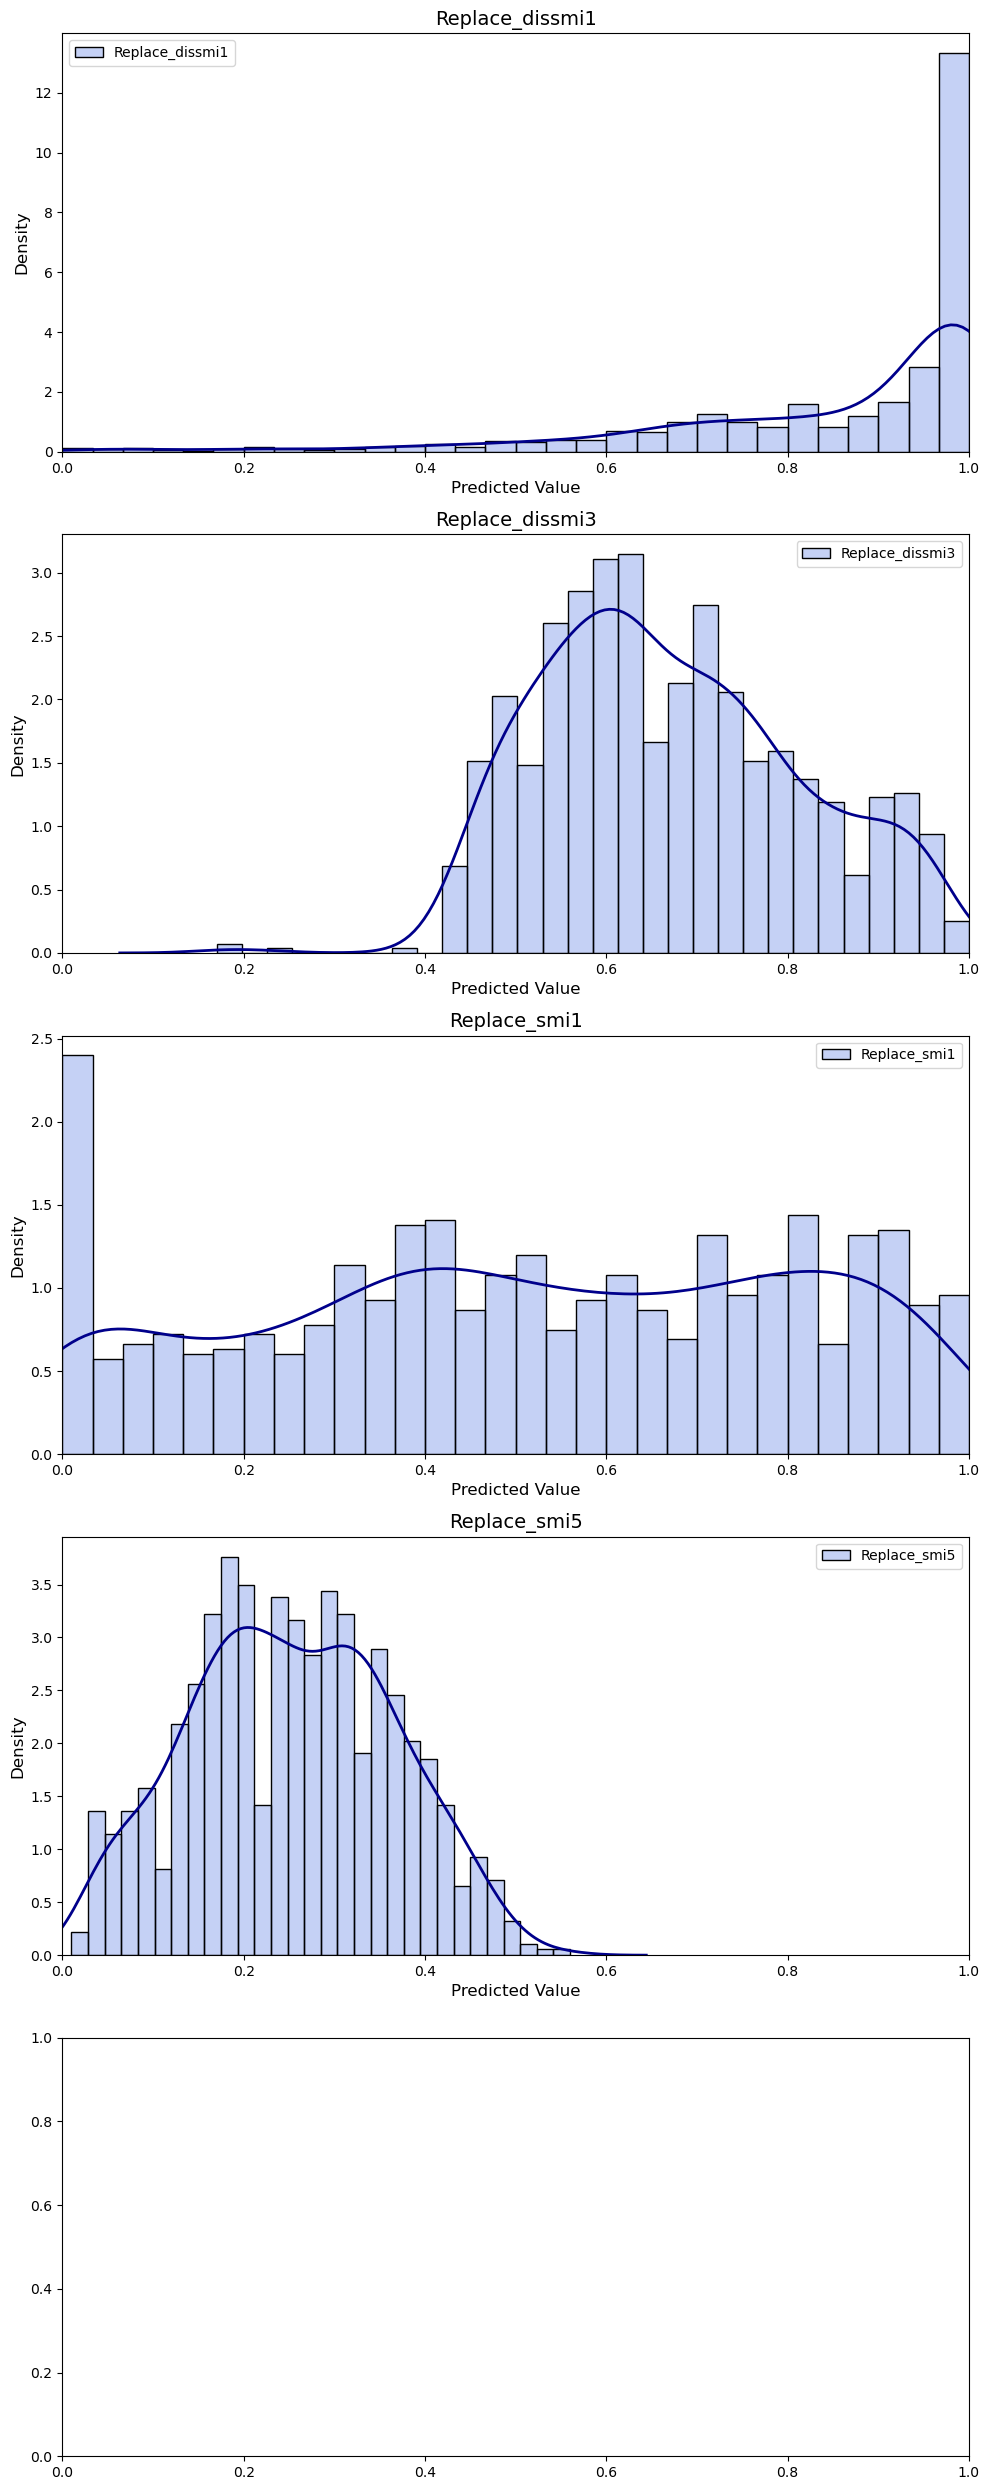

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group all predictions into a dictionary
y_sets = {
    # 'Original': y_pred_ori,
    
    'Replace_dissmi1': y_pred3,
    'Replace_dissmi3': y_pred4,
    'Replace_smi1': y_pred1,
    'Replace_smi5': y_pred2,
}

# Create 5 subplots, one for each set
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 25))

# Plot each set in its own axis
for ax, (label, y) in zip(axs, y_sets.items()):
    sns.histplot(y, bins=30, stat='density', color='royalblue', alpha=0.3, ax=ax, label=label)
    sns.kdeplot(y, color='darkblue', linewidth=2, ax=ax)
    ax.set_title(label, fontsize=14)
    ax.set_xlabel("Predicted Value", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_xlim(0, 1)  # Fix x-axis range
    ax.legend()

plt.tight_layout()
plt.show()

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group all predictions into a dictionary
y_sets = {
    # 'Original': y_pred_ori,
    
    'Replace_dissmi1': y_pred3,
    'Replace_dissmi3': y_pred4,
    'Replace_smi1': y_pred1,
    'Replace_smi5': y_pred2,
}

# Create 5 subplots, one for each set
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(10, 25))

# Plot each set in its own axis
for ax, (label, y) in zip(axs, y_sets.items()):
    sns.histplot(y, bins=30, stat='density', color='royalblue', alpha=0.3, ax=ax, label=label)
    sns.kdeplot(y, color='darkblue', linewidth=2, ax=ax)
    # ax.set_title(label, fontsize=14)
    ax.set_xlabel("Predicted Value", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.set_xlim(0, 1)  # Fix x-axis range
    ax.legend()

plt.tight_layout()
plt.show()

'/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/code/notebooks'

In [110]:
for label, y in y_sets.items():
    plt.figure(figsize=(8, 6))
    sns.histplot(y, bins=30, stat='density', color='royalblue', alpha=0.3, label=label)
    sns.kdeplot(y, color='darkblue', linewidth=2)
    plt.title(label, fontsize=14)
    plt.xlabel("Predicted Probabilities", fontsize=12)
    plt.ylabel("Density", fontsize=12)
    plt.xlim(0, 1)
    plt.legend()
    plt.tight_layout()
    
    # Save each figure
    plt.savefig(f"../results/{label}_predicted_distribution.png", dpi=300, bbox_inches="tight")
    plt.close()


In [163]:
# Reformat plots
import matplotlib.pyplot as plt
import seaborn as sns

# y_sets = {
#     'Original': y_pred_ori,
#     'Replace_dissmi1': y_pred3,
#     'Replace_dissmi3': y_pred4,
#     'Replace_smi1': y_pred1,
#     'Replace_smi5': y_pred2,
# }

for label, y in y_sets.items():
    plt.figure(figsize=(8, 6))
    sns.histplot(y, bins=30, stat='density', color='royalblue', alpha=0.3, label=label)
    sns.kdeplot(y, color='darkblue', linewidth=2)
    # plt.title(label, fontsize=14)
    # plt.xlabel("Predicted Probabilities", fontsize=20)
    # plt.ylabel("Density", fontsize=20)
    plt.xlabel("Predicted Probabilities", fontsize=20, labelpad=15)
    plt.ylabel("Density", fontsize=20, labelpad=15)
    plt.tick_params(axis="both", which="major", labelsize=20, pad=8)  
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlim(0, 1)
    # plt.legend()
    plt.tight_layout()
    
    # Save each figure
    plt.savefig(f"../results/{label}_prob_2ndround.png", dpi=500, bbox_inches="tight")
    plt.close()

In [61]:
x_smi_ori.shape

(1000, 768)

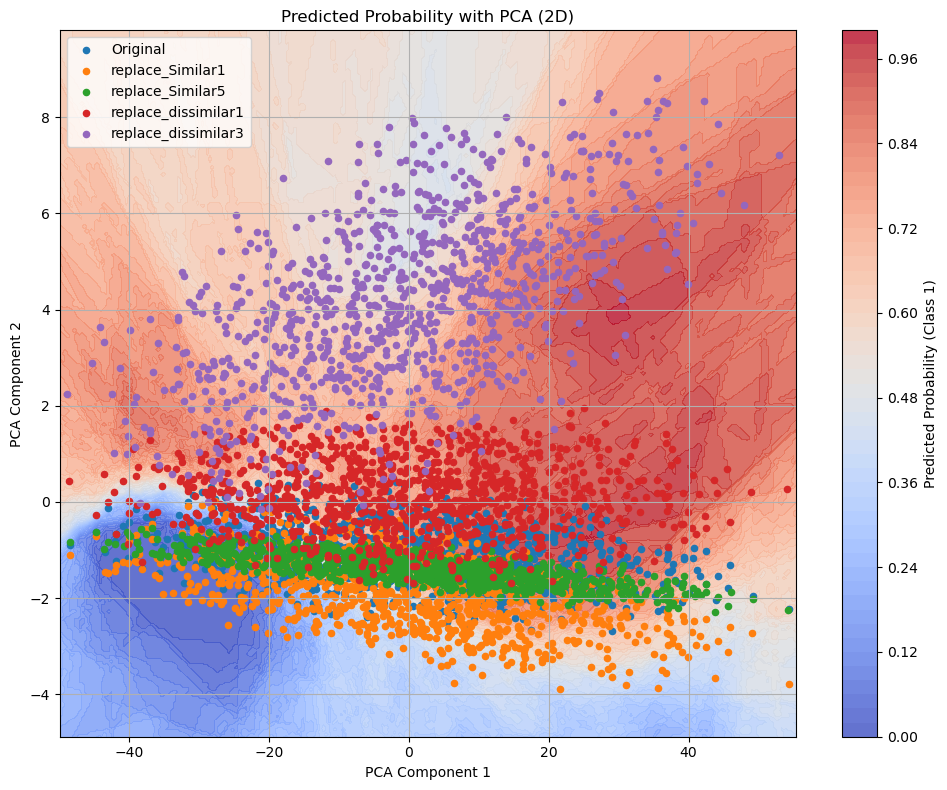

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

all_data = pd.concat([x_smi_ori, x_smi_similar1, x_smi_similar2, x_smi_similar3, x_smi_similar4], ignore_index=True)
pca = PCA(n_components=2, random_state=42)
all_data_pca = pca.fit_transform(all_data)

x_ori_2d = pca.transform(x_smi_ori)
x_sim1_2d = pca.transform(x_smi_similar1)
x_sim2_2d = pca.transform(x_smi_similar2)
x_sim3_2d = pca.transform(x_smi_similar3)
x_sim4_2d = pca.transform(x_smi_similar4)

x_min, x_max = all_data_pca[:, 0].min() - 1, all_data_pca[:, 0].max() + 1
y_min, y_max = all_data_pca[:, 1].min() - 1, all_data_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

grid_pca = np.c_[xx.ravel(), yy.ravel()]
grid_original_space = pca.inverse_transform(grid_pca)
Z_prob = model_clf_update.predict_proba(grid_original_space)[:, 1]
Z_prob = Z_prob.reshape(xx.shape)

plt.figure(figsize=(10, 8))
contour = plt.contourf(xx, yy, Z_prob, levels=50, cmap="coolwarm", alpha=0.8)
cbar = plt.colorbar(contour)
cbar.set_label("Predicted Probability (Class 1)")

plt.scatter(x_ori_2d[:, 0], x_ori_2d[:, 1], label='Original', s=20)
plt.scatter(x_sim1_2d[:, 0], x_sim1_2d[:, 1], label='replace_Similar1', s=20)
plt.scatter(x_sim2_2d[:, 0], x_sim2_2d[:, 1], label='replace_Similar5', s=20)
plt.scatter(x_sim3_2d[:, 0], x_sim3_2d[:, 1], label='replace_dissimilar1', s=20)
plt.scatter(x_sim4_2d[:, 0], x_sim4_2d[:, 1], label='replace_dissimilar3', s=20)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Predicted Probability with PCA (2D)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


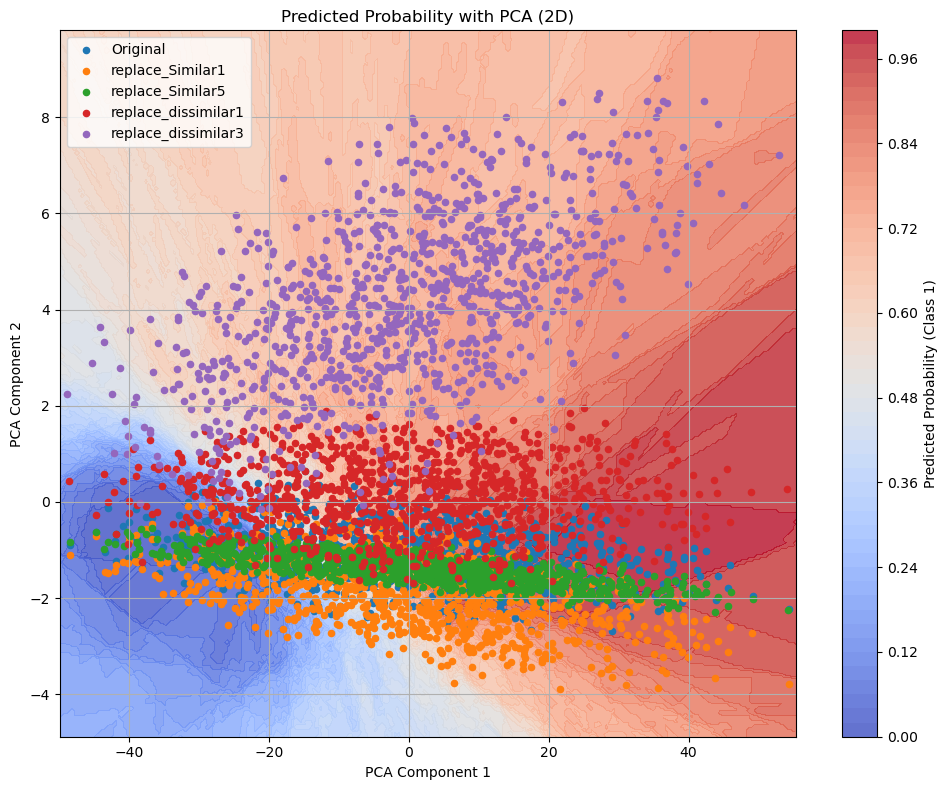

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

all_data = pd.concat([x_smi_ori, x_smi_similar1, x_smi_similar2, x_smi_similar3, x_smi_similar4], ignore_index=True)
pca = PCA(n_components=2, random_state=42)
all_data_pca = pca.fit_transform(all_data)

x_ori_2d = pca.transform(x_smi_ori)
x_sim1_2d = pca.transform(x_smi_similar1)
x_sim2_2d = pca.transform(x_smi_similar2)
x_sim3_2d = pca.transform(x_smi_similar3)
x_sim4_2d = pca.transform(x_smi_similar4)

x_min, x_max = all_data_pca[:, 0].min() - 1, all_data_pca[:, 0].max() + 1
y_min, y_max = all_data_pca[:, 1].min() - 1, all_data_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

grid_pca = np.c_[xx.ravel(), yy.ravel()]
grid_original_space = pca.inverse_transform(grid_pca)
Z_prob = model_clf.predict_proba(grid_original_space)[:, 1]
Z_prob = Z_prob.reshape(xx.shape)

plt.figure(figsize=(10, 8))
contour = plt.contourf(xx, yy, Z_prob, levels=50, cmap="coolwarm", alpha=0.8)
cbar = plt.colorbar(contour)
cbar.set_label("Predicted Probability (Class 1)")

plt.scatter(x_ori_2d[:, 0], x_ori_2d[:, 1], label='Original', s=20)
plt.scatter(x_sim1_2d[:, 0], x_sim1_2d[:, 1], label='replace_Similar1', s=20)
plt.scatter(x_sim2_2d[:, 0], x_sim2_2d[:, 1], label='replace_Similar5', s=20)
plt.scatter(x_sim3_2d[:, 0], x_sim3_2d[:, 1], label='replace_dissimilar1', s=20)
plt.scatter(x_sim4_2d[:, 0], x_sim4_2d[:, 1], label='replace_dissimilar3', s=20)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Predicted Probability with PCA (2D)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [73]:
pca.explained_variance_ratio_

array([0.97249903, 0.01703894])

In [77]:
# Now select samples based on new model

In [86]:
info_path = '/Users/haoliu/Documents/Hao/Fordham/Cheminformatics/MD/Amphiphiles/info_new_molecules.csv'
df_info = pd.read_csv(info_path)
df_info

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,ID,Name,Molecular_Formula,InChI,SMILES
0,A1,Decanal,C10H20O,InChI=1S/C10H20O/c1-2-3-4-5-6-7-8-9-10-11/h10H...,CCCCCCCCCC=O
1,A2,Geraniol,C10H18O,"InChI=1S/C10H18O/c1-9(2)5-4-6-10(3)7-8-11/h5,7...",CC(=CCC/C(=C/CO)/C)C
2,A3,Hexadecanoic acid,C16H32O2,InChI=1S/C16H32O2/c1-2-3-4-5-6-7-8-9-10-11-12-...,CCCCCCCCCCCCCCCC(=O)O
3,A4,Myristoleic acid,C14H26O2,InChI=1S/C14H26O2/c1-2-3-4-5-6-7-8-9-10-11-12-...,CCCC/C=C\CCCCCCCC(=O)O
4,A5,Glycine octylester,C10H22ClNO2,InChI=1S/C10H21NO2.ClH/c1-2-3-4-5-6-7-8-13-10(...,CCCCCCCCOC(=O)CN.Cl
5,A6,Perfluorooctanoic acid,C8HF15O2,"InChI=1S/C8HF15O2/c9-2(10,1(24)25)3(11,12)4(13...",C(=O)(C(C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)F)(F)F...
6,A7,"1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid",C8H5F13O3S,"InChI=1S/C8H5F13O3S/c9-3(10,1-2-25(22,23)24)4(...",C(CS(=O)(=O)O)C(C(C(C(C(C(F)(F)F)(F)F)(F)F)(F)...
7,A8,Heptadecafluorooctanesulfonic acid potassium salt,C8F17KO3S,"InChI=1S/C8HF17O3S.K/c9-1(10,3(13,14)5(17,18)7...",C(C(C(C(C(F)(F)S(=O)(=O)[O-])(F)F)(F)F)(F)F)(C...


In [87]:
def prepare_dispense_df_model(model, x_smi, df_new, df_info, prob_range=(0.7, 0.9), sample_n=10, random_state=None):
    """
    Select samples whose predicted probability lies within a given range,
    randomly choose N from them, transform back to concentrations,
    and generate a dispense file.

    Parameters
    ----------
    model : sklearn-like classifier with predict_proba
        Your trained classification model.
    x_smi : array-like
        Latent space representation of samples.
    df_new : DataFrame
        The original dataframe corresponding to x_smi.
    df_info : DataFrame
        Amphiphile information dataframe.
    prob_range : tuple(float, float)
        Probability range (min_prob, max_prob) for filtering.
    sample_n : int
        Number of samples to select after filtering.
    random_state : int, optional
        Random seed for reproducibility.

    Returns
    -------
    dispense_df : DataFrame
        Dispense file ready for experiments.
    """
    # Predict probabilities
    y_pred = model.predict_proba(x_smi)[:, 1]

    # Filter by probability range
    mask = (y_pred >= prob_range[0]) & (y_pred <= prob_range[1])
    filtered_df = df_new[mask]
    filtered_probs = y_pred[mask]

    # Print how many samples match the range
    print(f"Found {len(filtered_df)} samples in range {prob_range}")

    if len(filtered_df) == 0:
        raise ValueError(f"No samples found in probability range {prob_range}")

    # Randomly select N samples
    selected_df = filtered_df.sample(
        n=min(sample_n, len(filtered_df)),
        random_state=random_state
    )

    # Transform back to concentrations
    original_concentrations = extract_original_concentrations(selected_df, df_info)

    # Get dispense file
    solutes = original_concentrations.columns
    dispense_df = get_dispense_volume(original_concentrations, solutes, allow_zero=True)

    return original_concentrations, dispense_df, selected_df, filtered_probs

In [92]:
conc4, dispense_df4, selected_df4, probs4 = prepare_dispense_df_model(
    model_clf_update,
    x_smi_similar4,
    df_new4,
    df_info,
    prob_range=(0.9, 1),
    sample_n=10,
    random_state=42
)

Found 87 samples in range (0.9, 1)


In [95]:
conc2, dispense_df2, selected_df2, probs2 = prepare_dispense_df_model(
    model_clf_update,
    x_smi_similar2,
    df_new2,
    df_info,
    prob_range=(0.1, 0.2),
    sample_n=10,
    random_state=42
)

Found 272 samples in range (0.1, 0.2)


In [96]:
conc2

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Geraniol,Decanoate,Glycine octylester,Myristoleic acid,Hexadecanoic acid,Decanal,Glycerol monodecanoate
106,2.817273,1.461458,0.515991,4.011931,0.989415,0.645513,0.874456
439,0.625376,1.917940,3.720124,4.453836,0.208957,0.152425,0.924837
300,4.153218,1.598825,0.327128,2.479483,3.142641,0.336756,0.811493
460,1.515915,0.335256,0.161497,0.034869,0.345790,1.262075,0.182251
716,1.609646,2.121603,0.421990,0.461404,0.077187,0.343271,0.474008
490,1.831831,4.900628,2.880168,1.208877,2.551909,0.428533,0.171921
754,4.387699,0.848956,4.873676,1.385518,0.378531,1.262665,0.375881
167,0.672473,2.020386,4.801112,2.102034,0.592819,0.787707,0.453958
551,1.682251,1.059475,3.453497,3.304644,1.992934,0.408036,0.193614
878,1.503896,1.394701,2.064896,4.448495,1.825855,0.640492,0.035497


In [114]:
selected_df2

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,smi1,conc1,smi2,conc2,smi3,conc3,smi4,conc4,smi5,conc5,smi6,conc6,smi7,conc7,vesicles_formation
106,CC(=CCC/C(=C/CO)/C)C,1.339536,CCCCCCCCCC(=O)[O-],0.900754,CCCCCCCCOC(=O)CN.Cl,0.416069,CCCC/C=C\CCCCCCCC(=O)O,1.611821,CCCCCCCCCCCCCCCC(=O)O,0.687841,CCCCCCCCCC=O,0.498052,CCCCCCCCCC(=O)OCC(CO)O,0.628319,1
439,CC(=CCC/C(=C/CO)/C)C,0.485739,CCCCCCCCCC(=O)[O-],1.070878,CCCCCCCCOC(=O)CN.Cl,1.551835,CCCC/C=C\CCCCCCCC(=O)O,1.696319,CCCCCCCCCCCCCCCC(=O)O,0.189758,CCCCCCCCCC=O,0.141868,CCCCCCCCCC(=O)OCC(CO)O,0.654841,1
300,CC(=CCC/C(=C/CO)/C)C,1.639621,CCCCCCCCCC(=O)[O-],0.955060,CCCCCCCCOC(=O)CN.Cl,0.283017,CCCC/C=C\CCCCCCCC(=O)O,1.246884,CCCCCCCCCCCCCCCC(=O)O,1.421334,CCCCCCCCCC=O,0.290246,CCCCCCCCCC(=O)OCC(CO)O,0.594151,1
460,CC(=CCC/C(=C/CO)/C)C,0.922637,CCCCCCCCCC(=O)[O-],0.289123,CCCCCCCCOC(=O)CN.Cl,0.149709,CCCC/C=C\CCCCCCCC(=O)O,0.034275,CCCCCCCCCCCCCCCC(=O)O,0.296981,CCCCCCCCCC=O,0.816283,CCCCCCCCCC(=O)OCC(CO)O,0.167421,0
716,CC(=CCC/C(=C/CO)/C)C,0.959214,CCCCCCCCCC(=O)[O-],1.138347,CCCCCCCCOC(=O)CN.Cl,0.352057,CCCC/C=C\CCCCCCCC(=O)O,0.379398,CCCCCCCCCCCCCCCC(=O)O,0.074353,CCCCCCCCCC=O,0.295108,CCCCCCCCCC(=O)OCC(CO)O,0.387985,0
490,CC(=CCC/C(=C/CO)/C)C,1.040923,CCCCCCCCCC(=O)[O-],1.775059,CCCCCCCCOC(=O)CN.Cl,1.355878,CCCC/C=C\CCCCCCCC(=O)O,0.792484,CCCCCCCCCCCCCCCC(=O)O,1.267485,CCCCCCCCCC=O,0.356648,CCCCCCCCCC(=O)OCC(CO)O,0.158644,1
754,CC(=CCC/C(=C/CO)/C)C,1.684118,CCCCCCCCCC(=O)[O-],0.614621,CCCCCCCCOC(=O)CN.Cl,1.770481,CCCC/C=C\CCCCCCCC(=O)O,0.869416,CCCCCCCCCCCCCCCC(=O)O,0.321019,CCCCCCCCCC=O,0.816543,CCCCCCCCCC(=O)OCC(CO)O,0.319094,0
167,CC(=CCC/C(=C/CO)/C)C,0.514303,CCCCCCCCCC(=O)[O-],1.105385,CCCCCCCCOC(=O)CN.Cl,1.758050,CCCC/C=C\CCCCCCCC(=O)O,1.132058,CCCCCCCCCCCCCCCC(=O)O,0.465506,CCCCCCCCCC=O,0.580934,CCCCCCCCCC(=O)OCC(CO)O,0.374289,0
551,CC(=CCC/C(=C/CO)/C)C,0.986656,CCCCCCCCCC(=O)[O-],0.722451,CCCCCCCCOC(=O)CN.Cl,1.493690,CCCC/C=C\CCCCCCCC(=O)O,1.459695,CCCCCCCCCCCCCCCC(=O)O,1.096254,CCCCCCCCCC=O,0.342196,CCCCCCCCCC(=O)OCC(CO)O,0.176986,1
878,CC(=CCC/C(=C/CO)/C)C,0.917848,CCCCCCCCCC(=O)[O-],0.873258,CCCCCCCCOC(=O)CN.Cl,1.120014,CCCC/C=C\CCCCCCCC(=O)O,1.695339,CCCCCCCCCCCCCCCC(=O)O,1.038811,CCCCCCCCCC=O,0.494996,CCCCCCCCCC(=O)OCC(CO)O,0.034881,1


In [97]:
conc2_old, dispense_df2_old, selected_df2_old, probs2_old = prepare_dispense_df_model(
    model_clf,
    x_smi_similar2,
    df_new2,
    df_info,
    prob_range=(0.1, 0.2),
    sample_n=10,
    random_state=42
)

Found 55 samples in range (0.1, 0.2)


In [98]:
conc2_old

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Geraniol,Decanoate,Glycine octylester,Myristoleic acid,Hexadecanoic acid,Decanal,Glycerol monodecanoate
542,0.059854,2.255232,1.595396,0.203250,0.362228,0.682750,0.228040
84,0.257879,0.312814,0.282415,2.152808,0.385257,0.372634,0.861917
585,1.301985,0.024819,0.157434,0.589364,0.051171,0.783403,0.343874
228,0.634325,0.152923,0.165883,3.963817,0.410268,0.344877,0.170120
366,0.094167,0.139538,1.058242,0.697386,0.516457,0.293668,0.745309
880,0.319614,0.715379,0.562218,0.948549,0.578218,0.565212,0.326301
729,0.814171,0.760081,0.210513,0.929410,0.195149,1.018642,0.953788
498,0.888796,0.097629,0.058526,1.135103,0.163603,0.743768,0.841617
761,0.318987,1.198095,1.495831,0.589936,0.762997,0.082948,0.233895
219,0.629832,1.097992,0.244073,0.383444,2.388541,0.180869,0.439097


(array([  3.,   0.,   1., 117., 192., 219., 192., 124.,  84.,  68.]),
 array([0.17 , 0.253, 0.336, 0.419, 0.502, 0.585, 0.668, 0.751, 0.834,
        0.917, 1.   ]),
 <BarContainer object of 10 artists>)

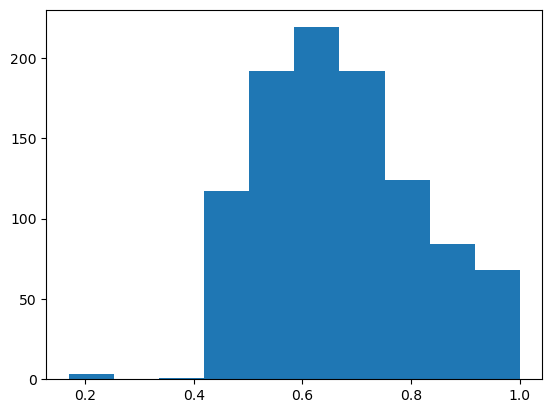

In [90]:
y_pred4_update = model_clf_update.predict_proba(x_smi_similar4)[:,1]
plt.hist(y_pred4_update)

In [99]:
dispense_df4

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Heptadecafluorooctanesulfonic acid potassium salt (50 mM),Heptadecafluorooctanesulfonic acid potassium salt (10 mM),Heptadecafluorooctanesulfonic acid potassium salt (2 mM),Decanoate (50 mM),Decanoate (10 mM),Decanoate (2 mM),Decylamine (50 mM),Decylamine (10 mM),Decylamine (2 mM),Perfluorooctanoic acid (50 mM),Perfluorooctanoic acid (10 mM),Perfluorooctanoic acid (2 mM),Decyl sodium sulfate (50 mM),Decyl sodium sulfate (10 mM),Decyl sodium sulfate (2 mM),"1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid (15 mM)","1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid (3 mM)",Glycerol monodecanoate (10 mM),Glycerol monodecanoate (2 mM)
851,0.0,18.7,0.0,11.9,0.0,0.0,13.1,0.0,0.0,4.2,0.0,0.0,17.8,0.0,0.0,6.0,0.0,14.1,0.0
1,14.9,0.0,0.0,7.7,0.0,0.0,10.2,0.0,0.0,0.0,0.0,3.8,18.7,0.0,0.0,15.3,0.0,0.0,15.9
392,8.2,0.0,0.0,12.2,0.0,0.0,7.3,0.0,0.0,0.0,6.0,0.0,13.1,0.0,0.0,10.5,0.0,6.2,0.0
357,4.3,0.0,0.0,13.6,0.0,0.0,11.7,0.0,0.0,7.2,0.0,0.0,18.2,0.0,0.0,0.0,13.4,0.0,7.9
177,0.0,7.9,0.0,15.0,0.0,0.0,12.1,0.0,0.0,11.9,0.0,0.0,14.2,0.0,0.0,13.4,0.0,10.9,0.0
750,0.0,19.9,0.0,18.6,0.0,0.0,9.9,0.0,0.0,0.0,0.0,16.1,14.8,0.0,0.0,7.4,0.0,0.0,4.9
159,6.5,0.0,0.0,7.6,0.0,0.0,7.3,0.0,0.0,0.0,0.0,17.8,15.3,0.0,0.0,0.0,18.4,0.0,9.4
330,5.9,0.0,0.0,15.2,0.0,0.0,5.7,0.0,0.0,10.1,0.0,0.0,19.7,0.0,0.0,0.0,8.5,4.2,0.0
71,0.0,0.0,14.9,18.9,0.0,0.0,19.4,0.0,0.0,10.0,0.0,0.0,6.5,0.0,0.0,4.4,0.0,15.2,0.0
759,18.4,0.0,0.0,6.0,0.0,0.0,5.0,0.0,0.0,0.0,13.0,0.0,18.3,0.0,0.0,0.0,9.3,9.9,0.0


In [100]:
import joblib

# Save all objects into one file
joblib.dump(
    {
        "conc4": conc4,
        "dispense_df4": dispense_df4,
        "selected_df4": selected_df4,
        "probs4": probs4,

        "conc2": conc2,
        "dispense_df2": dispense_df2,
        "selected_df2": selected_df2,
        "probs2": probs2,

        "conc2_old": conc2_old,
        "dispense_df2_old": dispense_df2_old,
        "selected_df2_old": selected_df2_old,
        "probs2_old": probs2_old
    },
    "experiment_plan_20250810.joblib"
)


['experiment_plan_20250810.joblib']

In [103]:
# Load data
# data = joblib.load("experiment_plan_20250810.joblib")


# conc4 = data["conc4"]
# dispense_df4 = data["dispense_df4"]
# selected_df4 = data["selected_df4"]
# probs4 = data["probs4"]
# ...

In [105]:
conc4.to_csv('replace_dissmi3_fm_finetune_concentrations.csv', index=False)
dispense_df4.to_csv('replace_dissmi3_fm_finetune_dispensevolumne.csv', index=False)

conc2.to_csv('replace_smi5_fm_finetune_concentrations.csv', index=False)
dispense_df2.to_csv('replace_smi5_fm_finetune_dispensevolumne.csv', index=False)

conc2_old.to_csv('replace_smi5_fm_pre_concentrations.csv', index=False)
dispense_df2_old.to_csv('replace_smi5_fm_pre_dispensevolumne.csv', index=False)

In [107]:
pwd

'/Users/haoliu/Documents/GitHub/FoundationModel_on_Liposome/code/notebooks'

In [115]:
# Plot the composition

In [120]:
conc4

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Heptadecafluorooctanesulfonic acid potassium salt,Decanoate,Decylamine,Perfluorooctanoic acid,Decyl sodium sulfate,"1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid",Glycerol monodecanoate
851,0.936083,2.971618,3.275927,1.048981,4.457934,0.451269,0.707441
1,3.720805,1.936016,2.556211,0.037571,4.685080,1.144185,0.158565
392,2.050226,3.054960,1.818406,0.301245,3.277372,0.790902,0.308728
357,1.075688,3.404888,2.934760,1.794424,4.545610,0.201647,0.078678
177,0.394334,3.741549,3.020775,2.980098,3.543276,1.008362,0.543516
750,0.997129,4.652539,2.487392,0.160807,3.693676,0.553224,0.048810
159,1.617263,1.893323,1.827449,0.178123,3.817229,0.275536,0.093926
330,1.482237,3.789359,1.421330,2.519359,4.923272,0.128041,0.209769
71,0.149448,4.730949,4.853574,2.493618,1.613148,0.327925,0.757829
759,4.605664,1.489127,1.250952,0.647655,4.573748,0.139808,0.494673


In [155]:
import matplotlib.pyplot as plt

# Amphiphile keyword -> fixed color
amphiphile_colors = {
    # First set (7 amphiphiles)
    'Decanoic acid': 'blue',
    'Decanoate': 'orange',
    'Decylamine': 'green',
    'Decyltrimethyl ammonium bromid': 'red',
    'Decyl sodium sulfate': 'purple',
    'Decanol': 'brown',
    'Glycerol monodecanoate': 'pink',

    # Second set (8 amphiphiles)
    'Decanal': 'cyan',               # bright cyan
    'Geraniol': 'lime',              # neon-like lime
    'Hexadecanoic acid': 'gold',     # strong yellow-gold
    'Myristoleic acid': 'deepskyblue', # vivid blue (different from "blue")
    'Glycine octylester': 'crimson', # strong red-pink (not same as red/pink)
    'Perfluorooctanoic acid': 'darkviolet', # deep violet
    'Tridecafluorooctane-1-sulphonic acid': 'black', # solid black
    'Heptadecafluorooctanesulfonic acid': 'olive'    # earthy olive green
}

def get_feature_color(feature, color_map=amphiphile_colors):
    # Sort keys by length (longest first) to avoid substring conflicts
    for key in sorted(color_map.keys(), key=len, reverse=True):
        if key.lower() in feature.lower():
            return color_map[key]
    return "gray"  # default if no match


def plot_samples(df, title):
    num_samples = df.shape[0]
    features = df.columns

    plt.figure(figsize=(15, num_samples * 0.5))

    used_labels = set()  # to avoid duplicate legend entries

    for i in range(num_samples):
        sample = df.iloc[i, :]
        left = 0
        for feature in features:
            # print(feature)
            color = get_feature_color(feature)
            # print(color)
            # print('='*10)
            label = None
            if feature not in used_labels:
                label = feature
                used_labels.add(feature)
            plt.barh(
                i,
                sample[feature],
                left=left,
                color=color,
                label=label
            )
            left += sample[feature]

    plt.xlabel('Concentration (mM)')
    plt.ylabel('Sample Index')
    plt.title(title)
    plt.legend(
        loc='upper center', 
        bbox_to_anchor=(0.5, -0.1), 
        ncol=4, 
        frameon=False
    )
    plt.tight_layout()
    plt.show()


In [134]:
conc4

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Heptadecafluorooctanesulfonic acid potassium salt,Decanoate,Decylamine,Perfluorooctanoic acid,Decyl sodium sulfate,"1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid",Glycerol monodecanoate
851,0.936083,2.971618,3.275927,1.048981,4.457934,0.451269,0.707441
1,3.720805,1.936016,2.556211,0.037571,4.685080,1.144185,0.158565
392,2.050226,3.054960,1.818406,0.301245,3.277372,0.790902,0.308728
357,1.075688,3.404888,2.934760,1.794424,4.545610,0.201647,0.078678
177,0.394334,3.741549,3.020775,2.980098,3.543276,1.008362,0.543516
750,0.997129,4.652539,2.487392,0.160807,3.693676,0.553224,0.048810
159,1.617263,1.893323,1.827449,0.178123,3.817229,0.275536,0.093926
330,1.482237,3.789359,1.421330,2.519359,4.923272,0.128041,0.209769
71,0.149448,4.730949,4.853574,2.493618,1.613148,0.327925,0.757829
759,4.605664,1.489127,1.250952,0.647655,4.573748,0.139808,0.494673


Heptadecafluorooctanesulfonic acid potassium salt
olive
Decanoate
orange
Decylamine
green
Perfluorooctanoic acid
darkviolet
Decyl sodium sulfate
purple
1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid
black
Glycerol monodecanoate
pink
Heptadecafluorooctanesulfonic acid potassium salt
olive
Decanoate
orange
Decylamine
green
Perfluorooctanoic acid
darkviolet
Decyl sodium sulfate
purple
1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid
black
Glycerol monodecanoate
pink
Heptadecafluorooctanesulfonic acid potassium salt
olive
Decanoate
orange
Decylamine
green
Perfluorooctanoic acid
darkviolet
Decyl sodium sulfate
purple
1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid
black
Glycerol monodecanoate
pink
Heptadecafluorooctanesulfonic acid potassium salt
olive
Decanoate
orange
Decylamine
green
Perfluorooctanoic acid
darkviolet
Decyl sodium sulfate
purple
1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid
black
Glycerol monodecanoate
pink
Heptadecafluorooctanesulfonic acid potassium salt
olive
Deca

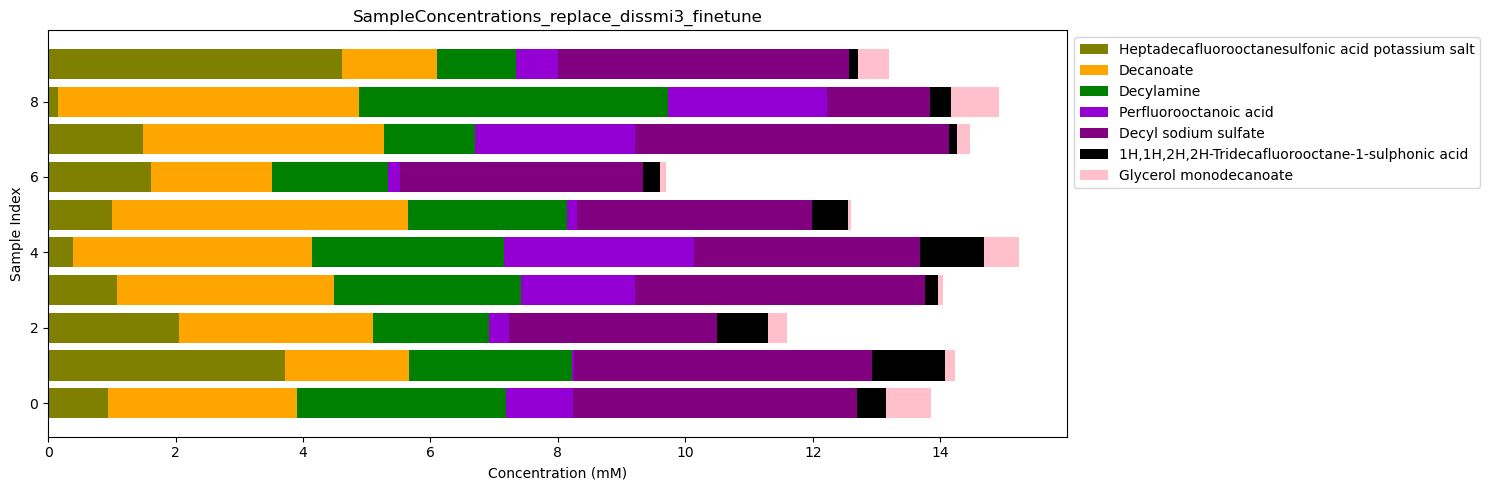

In [138]:
plot_samples(conc4, 'SampleConcentrations_replace_dissmi3_finetune')

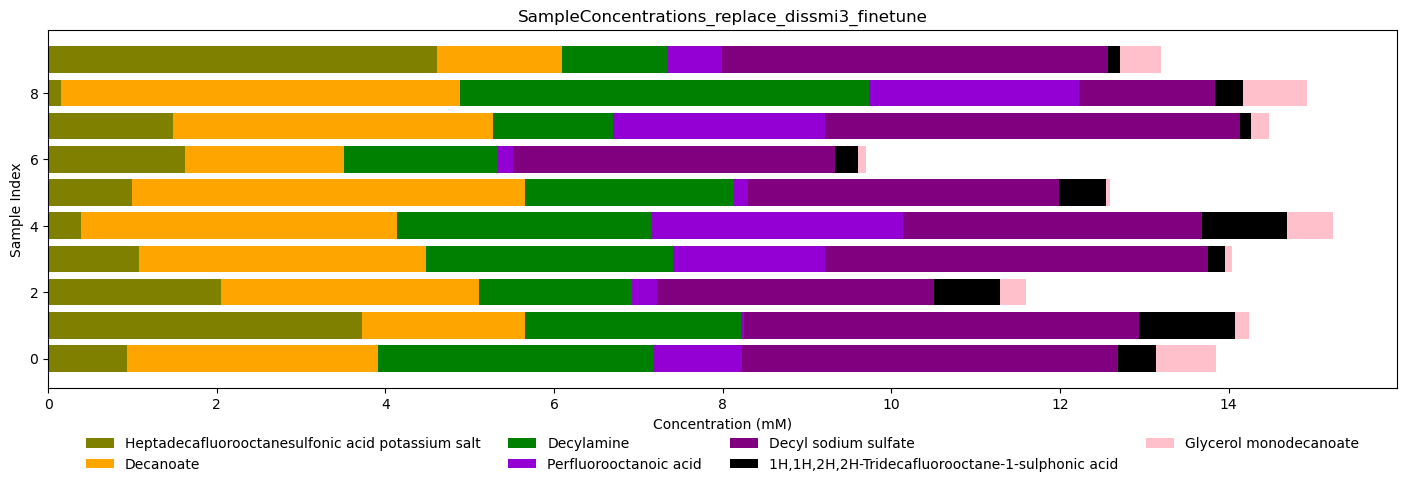

In [156]:
plot_samples(conc4, 'SampleConcentrations_replace_dissmi3_finetune')

In [ ]:
#get the previous conc4

In [145]:
info_path = '/Users/haoliu/Documents/Hao/Fordham/Cheminformatics/MD/Amphiphiles/info_new_molecules.csv'
df_info = pd.read_csv(info_path)

output_file = "selected_samples_20250603.pkl"

with open(output_file, 'rb') as f:
    loaded_list = pickle.load(f)

In [146]:
high_samples0 = loaded_list[0]
low_samples0 = loaded_list[1]
high_samples1 = loaded_list[2]
low_samples1 = loaded_list[3]
high_samples2 = loaded_list[4]
low_samples2 = loaded_list[5]
high_samples3 = loaded_list[6]
low_samples3 = loaded_list[7]
high_samples4 = loaded_list[8]
low_samples4 = loaded_list[9]

In [147]:
datasets = [
    high_samples0, low_samples0, high_samples1, low_samples1,
    high_samples2, low_samples2, high_samples3, low_samples3,
    high_samples4, low_samples4
]

# Process all datasets
original_concentrations = [
    extract_original_concentrations(df, df_info) for df in datasets
]

In [ ]:
plot_samples(conc2, 'SampleConcentrations_replace_smi5_finetune')

In [153]:
high_samples4_concentrations = extract_original_concentrations(high_samples4, df_info)
high_samples4_concentrations

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/rdkit/Chem/PandasPatcher.py:132: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  for col in df_subset.columns[df_subset.applymap(MolFormatter.is_mol).any()]


,Heptadecafluorooctanesulfonic acid potassium salt,Decanoate,Decylamine,Perfluorooctanoic acid,Decyl sodium sulfate,"1H,1H,2H,2H-Tridecafluorooctane-1-sulphonic acid",Glycerol monodecanoate
7,0.392659,4.681768,3.010242,4.383594,3.969481,0.729531,0.894575
631,0.043950,0.823769,0.373399,0.192858,4.552304,0.731846,0.657095
518,0.001171,3.758962,3.137697,2.077208,2.835485,0.149493,0.373944
441,0.027968,1.841873,0.573806,1.240608,4.560872,0.441425,0.789804
704,2.792021,4.191381,1.136767,0.845997,4.600566,0.503227,0.403519
146,4.239865,4.696790,4.429779,1.338893,3.685971,1.168103,0.247552
388,2.184510,4.728892,3.561855,0.043183,4.002834,1.049585,0.717579
380,1.330809,3.840554,0.471902,2.368536,1.971140,0.310727,0.099312
288,0.863312,4.014255,0.039877,2.284950,4.619098,0.670757,0.914307
677,2.044312,2.624694,0.219176,0.065846,4.939356,0.237690,0.038017


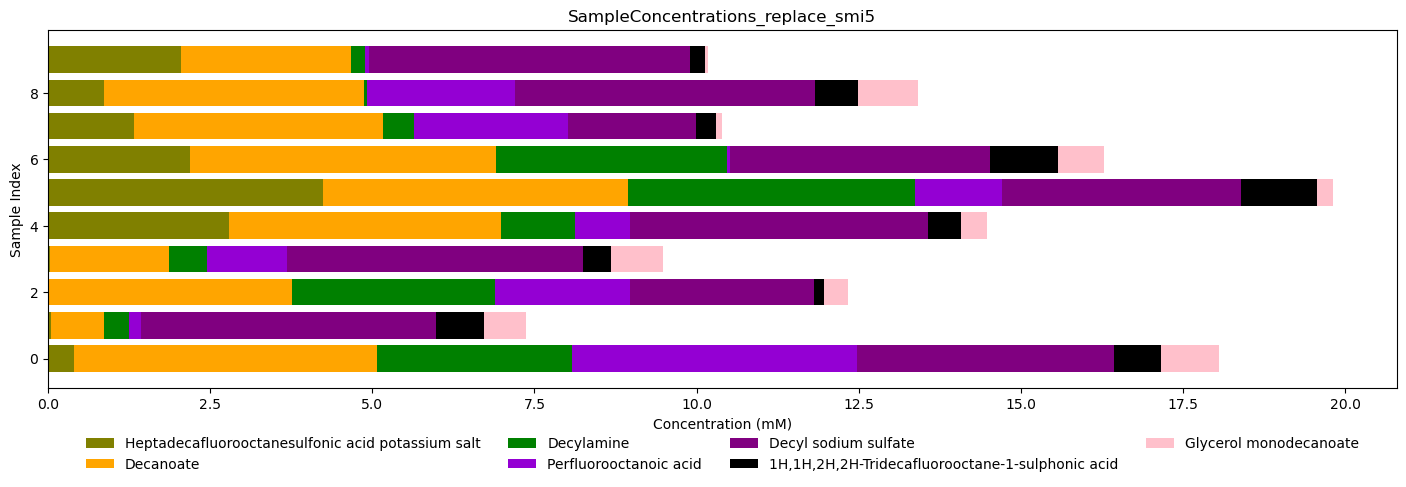

In [157]:
plot_samples(high_samples4_concentrations, 'SampleConcentrations_replace_smi5')

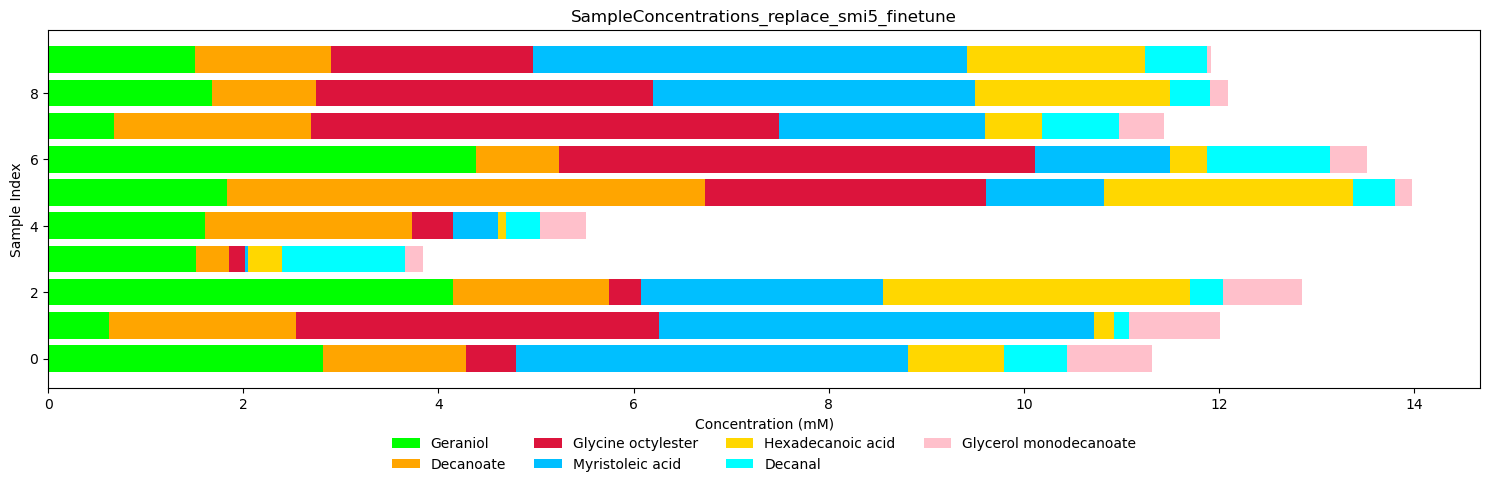

In [158]:
plot_samples(conc2, 'SampleConcentrations_replace_smi5_finetune')

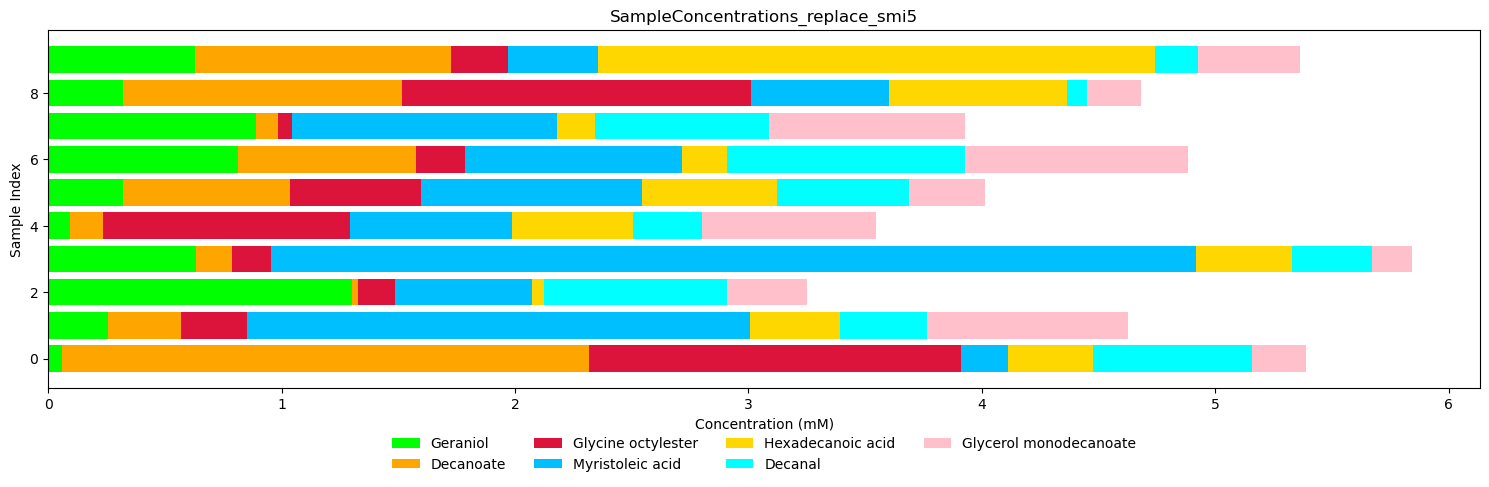

In [159]:
plot_samples(conc2_old, 'SampleConcentrations_replace_smi5')

In [149]:
highprob_replace_smi5 = pd.read_csv('original_concentrations_highprob_replace_smi5.csv')

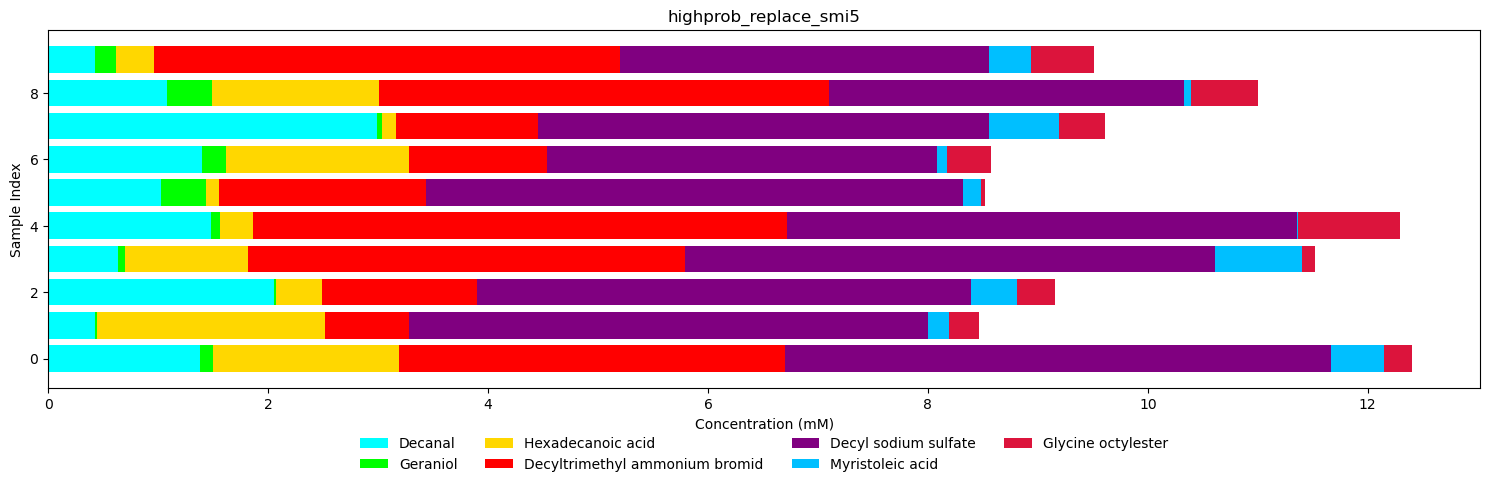

In [160]:
plot_samples(highprob_replace_smi5, 'highprob_replace_smi5')

In [161]:
# Do a hierarchical clustering